1it [00:00,  6.83it/s]


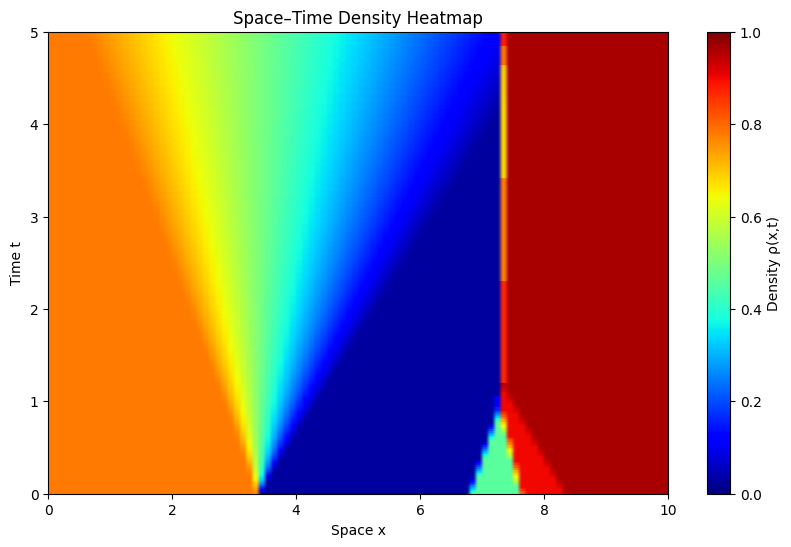

In [4]:
from operator_data_pipeline import get_nfv_dataset
from numerical_methods.plotter import plot_grid_density, animate_density

nx = 100
nt = 500
dx = 0.1
dt = 0.01
grids = get_nfv_dataset(1, nx, nt, dx, dt, max_steps=5)
plot_grid_density(grids[0], nx, nt, dx, dt)
# animate_density(grids[0], nx, nt, dx, dt, output_name='test.gif')
# animate_density(grids[0].T, nt, nx, dt, dx, output_name='test1.gif',skip_frames=2)

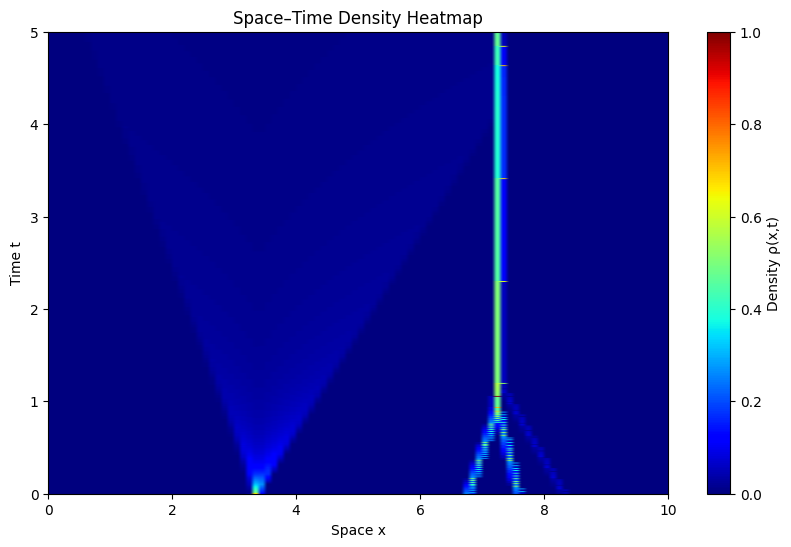

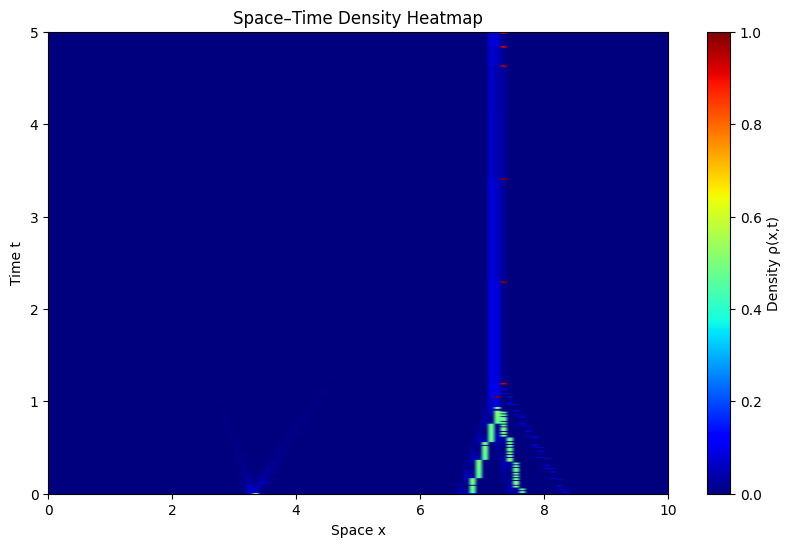

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Compute first order derivative using finite difference which sums the du/dt and du/dx
def first_order_derivative(grid):
    du_dt = np.abs((grid[1:] - grid[:-1]) / dt)
    du_dx = np.abs((grid[:, 1:] - grid[:, :-1]) / dx)

    # Make sure the grids are the same size
    du_dt = np.concatenate([du_dt, np.zeros((1, nx))], axis=0)
    du_dx = np.concatenate([du_dx, np.zeros((nt, 1))], axis=1)
    return du_dt + du_dx

# Compute second order derivative using finite difference which sums the du/dt and du/dx
def second_order_derivative(grid):
    du_dt = np.abs((grid[2:] - 2*grid[1:-1] + grid[:-2]) / dt**2)
    du_dx = np.abs((grid[:, 2:] - 2*grid[:, 1:-1] + grid[:, :-2]) / dx**2)

    # Make sure the grids are the same size
    du_dt = np.concatenate([du_dt, np.zeros((2, nx))], axis=0)
    du_dx = np.concatenate([du_dx, np.zeros((nt, 2))], axis=1)
    return du_dt + du_dx

# Compute first order derivative grid, and second order derivative grid
first_order_derivative_grid = first_order_derivative(grids[0])
second_order_derivative_grid = second_order_derivative(grids[0])

# Normalize the grids between 0 and 1
first_order_derivative_grid = (first_order_derivative_grid - first_order_derivative_grid.min()) / (first_order_derivative_grid.max() - first_order_derivative_grid.min())
second_order_derivative_grid = (second_order_derivative_grid - second_order_derivative_grid.min()) / (second_order_derivative_grid.max() - second_order_derivative_grid.min())

# Plot the grids
plot_grid_density(first_order_derivative_grid, nx, nt, dx, dt)
plot_grid_density(second_order_derivative_grid, nx, nt, dx, dt)
plt.show()


1it [00:00, 12.33it/s]


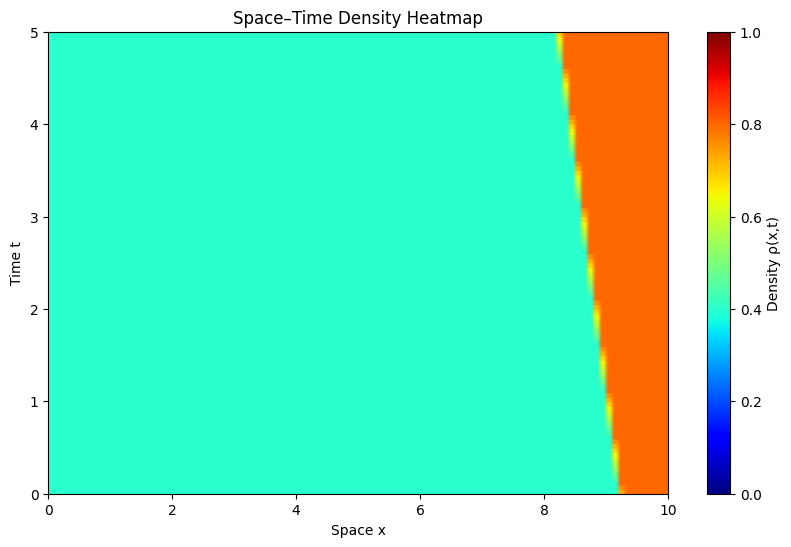

In [8]:
from operator_data_pipeline import PiecewiseRandom
from nfv.problem import Problem
from nfv.flows import Greenshield
from nfv.solvers import LaxHopf
import torch
import numpy as np
from numerical_methods.plotter import plot_grid_density, animate_density

nx = 100
nt = 500
dx = 0.1
dt = 0.01
max_steps = 2
ics = [PiecewiseRandom(ks=[0.4, 0.8], x_noise=False) for _ in range(1)]
problem = Problem(nx=nx, nt=nt, dx=dx, dt=dt, ic=ics, flow=Greenshield())
grids = problem.solve(LaxHopf, batch_size=4, dtype=torch.float64, progressbar=True).cpu().numpy()
plot_grid_density(grids[0], nx, nt, dx, dt)